In [1]:
# !pip install opencv-python scikit-learn scikit-image matplotlib spectral keras_tuner vis
# !pip install tensorflow numpy pandas
# !pip install spectral

In [2]:
import tensorflow as tf

2023-07-23 14:24:16.042993: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from tensorflow import keras as keras
from keras import layers as layers

In [4]:
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf

In [5]:
import pandas as pd

In [6]:
from spectral.io import envi as envi
from spectral import imshow

In [7]:
from sklearn.decomposition import IncrementalPCA

In [8]:
import sys

In [9]:
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [11]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\mvl\wheat\data\BULK\\"
    SLASH="\\"

In [12]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TOTAL_IMAGE_COUNT = 2400
IMAGE_COUNT = int(TOTAL_IMAGE_COUNT/4)
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [13]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 2*NUM_VARIETIES

LEARNING_RATE_BASE = 0.0001

In [14]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(0).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [15]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [16]:
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [17]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [18]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_IC_"+str(TOTAL_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [19]:
train_dataset = []
train_dataset_label = []
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    train_dataset= train_dataset + np.load(dataset_file_name(v)+"_train_dataset.npy").tolist()
    train_dataset_label = train_dataset_label + np.load(dataset_file_name(v)+"_train_dataset_label.npy").tolist()
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
train_dataset = np.array(train_dataset)
train_dataset_label = np.array(train_dataset_label)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from keras.layers import Input, Conv2D, MaxPool2D, MaxPooling2D, Activation, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.core import Dropout
from keras.optimizers import Adam

In [21]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:])       
        
    return data

In [22]:
def inception(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool,activation_type='relu'):
    path1 = Conv2D(filters_1x1,        (1, 1), padding='same', activation=activation_type)(x)
    
    path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation=activation_type)(x)
    path2 = Conv2D(filters_3x3,        (1, 1), padding='same', activation=activation_type)(path2)
    
    path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation=activation_type)(x)
    path3 = Conv2D(filters_5x5,        (1, 1), padding='same', activation=activation_type)(path3)
    
    path4 = MaxPool2D((3, 3),  strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters_pool,       (1, 1), padding='same', activation=activation_type)(path4)
    
    return tf.concat([path1, path2, path3, path4], axis=3)

In [23]:
def auxiliary_classifier(x,num_classes,activation_type='relu'):
    aux = AveragePooling2D((5, 5), strides=3)(x)
    aux = Conv2D(128, 1, padding='same', activation=activation_type)(aux)
    aux = Flatten()(aux)
    aux = Dense(1024, activation=activation_type)(aux)
    aux = Dropout(0.7)(aux)
    aux = Dense(num_classes, activation='softmax')(aux)
    return aux

In [24]:
def GoogleNetModel(data_num_rows, data_num_cols, num_input_chans=1, num_classes=NUM_VARIETIES, activation_type='relu', dropout_rate=0.0):

    inp = Input(shape=(data_num_rows, data_num_cols, num_input_chans))
    input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=train_dataset.shape[1:])(inp)
    x = Conv2D(64,  7, strides=2, padding='same', activation=activation_type)(input_tensor)
    x = MaxPooling2D(3, strides=2)(x)
    x = Conv2D(64,  1, strides=1, padding='same', activation=activation_type)(x)
    x = Conv2D(192, 3, strides=1, padding='same', activation=activation_type)(x)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=64 , filters_3x3_reduce=96 , filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool=32)
    x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool=64)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=192, filters_3x3_reduce=96 , filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool=64)
    
    aux1 = auxiliary_classifier(x,num_classes)
    
    x = inception(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
    x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
    x = inception(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
    
    aux2 = auxiliary_classifier(x,num_classes)
    
    x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
    x = inception(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs = inp, outputs = [out, aux1, aux2])

In [25]:
def getGoogleNetModel():
    learning_rate_base = LEARNING_RATE_BASE
    activation_type = ACTIVATION_TYPE
    wheat_types =  VARIETIES
    num_classes = len(wheat_types)
    dropout_rate = 0.4
    print("--------------Load Data--------------")

    x_training = np.array(train_dataset)
    labels_training = np.array(train_dataset_label)
    
    # Normalize the data
    x_training = normalizeDataWholeSeed(x_training)
    
    # Extract some information
    num_train = x_training.shape[0]
    N_spatial = x_training.shape[1:3]
    N_channel = x_training.shape[3]
    
    print("--------------Done--------------")
    
    ############ Create a model ############
    print("--------------Create a model--------------")
    
    # Generate a model
    model = GoogleNetModel(data_num_rows = N_spatial[0], 
                           data_num_cols = N_spatial[1],
                           num_input_chans = N_channel, 
                           num_classes = num_classes,
                           activation_type = activation_type,
                           dropout_rate = dropout_rate)

    # Compile the model
    adam_opt = Adam(learning_rate=LEARNING_RATE_BASE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    model.compile(optimizer=adam_opt, loss=[losses.sparse_categorical_crossentropy,losses.sparse_categorical_crossentropy,losses.sparse_categorical_crossentropy],loss_weights=[1, 0.3, 0.3],metrics=['accuracy'])
    print("---------Completed---------")
    return model

In [26]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

In [27]:
model = getGoogleNetModel()

--------------Load Data--------------
--------------Done--------------
--------------Create a model--------------


2023-07-23 14:29:37.420727: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


---------Completed---------


In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 168  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 16  0           ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  526912      ['resizing[0][0]']               
                                )                                                             

In [29]:
x_train = []
y_train = []
x_val = []
y_val = []

for i in range(len(train_dataset)):
    if i%5==0:
        x_val.append(train_dataset[i])
        y_val.append(train_dataset_label[i])
    else:
        x_train.append(train_dataset[i])
        y_train.append(train_dataset_label[i])
        
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = [y_train,y_train,y_train]

x_val = np.array(x_val)

y_val = np.array(y_val)
y_val = [y_val,y_val,y_val]

In [30]:
train_eva = []
test_eva = []

In [31]:
history_dataframe = pd.DataFrame() 

In [32]:
tic = start_timer()
for x in range(0,2AttributeError: module 'tensorflow' has no attribute 'placeholder'

0):
    print("\nEpoch: ",x+1)
    history = model.fit(x_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, validation_data=(x_val, y_val), shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    print("for testing")
    test_eva.append(model.evaluate(test_dataset,test_dataset_label))
    print("for training")
    train_eva.append(model.evaluate(train_dataset,train_dataset_label))
toc = end_timer()
show_time(tic,toc)

Testing started

Epoch:  1
768/768 - 2060s - loss: 2.2148 - dense_4_loss: 1.3842 - dense_1_loss: 1.3841 - dense_3_loss: 1.3844 - dense_4_accuracy: 0.2590 - dense_1_accuracy: 0.2620 - dense_3_accuracy: 0.2562 - val_loss: 2.2084 - val_dense_4_loss: 1.3806 - val_dense_1_loss: 1.3790 - val_dense_3_loss: 1.3802 - val_dense_4_accuracy: 0.2500 - val_dense_1_accuracy: 0.2565 - val_dense_3_accuracy: 0.2500 - 2060s/epoch - 3s/step
for testing
60/60 [==============================] - 59s 964ms/step - loss: 2.2085 - dense_4_loss: 1.3806 - dense_1_loss: 1.3792 - dense_3_loss: 1.3804 - dense_4_accuracy: 0.2500 - dense_1_accuracy: 0.2531 - dense_3_accuracy: 0.2500
for training
240/240 [==============================] - 230s 959ms/step - loss: 2.2081 - dense_4_loss: 1.3804 - dense_1_loss: 1.3788 - dense_3_loss: 1.3801 - dense_4_accuracy: 0.2500 - dense_1_accuracy: 0.2548 - dense_3_accuracy: 0.2500

Epoch:  2
768/768 - 2046s - loss: 2.0220 - dense_4_loss: 1.2431 - dense_1_loss: 1.3209 - dense_3_loss: 1

In [33]:
history_dataframe

,loss,dense_4_loss,dense_1_loss,dense_3_loss,dense_4_accuracy,dense_1_accuracy,dense_3_accuracy,val_loss,val_dense_4_loss,val_dense_1_loss,val_dense_3_loss,val_dense_4_accuracy,val_dense_1_accuracy,val_dense_3_accuracy
0,2.214775,1.384218,1.384115,1.384402,0.258952,0.262044,0.256185,2.208357,1.380589,1.379005,1.380222,0.250000,0.256510,0.250000
1,2.021991,1.243097,1.320873,1.275432,0.385905,0.364421,0.366374,1.759118,1.055998,1.229847,1.113886,0.523438,0.485677,0.482422
2,1.762357,1.064846,1.203415,1.121621,0.479167,0.430827,0.441732,1.791978,1.099549,1.173777,1.134317,0.506510,0.485677,0.455729
3,1.689657,1.014455,1.159867,1.090802,0.516113,0.445475,0.454264,1.685558,1.021504,1.135391,1.078120,0.555990,0.502604,0.488932
4,1.654222,0.991729,1.133662,1.074642,0.536947,0.468424,0.460775,1.622526,0.972570,1.113289,1.053230,0.576172,0.507161,0.512370
5,1.624287,0.966531,1.123374,1.069150,0.551270,0.462402,0.465983,1.579232,0.939312,1.098149,1.034918,0.588542,0.518880,0.528646
6,1.598696,0.949377,1.109904,1.054494,0.569824,0.471842,0.479818,1.546858,0.914236,1.087496,1.021246,0.595703,0.520182,0.538411
7,1.576794,0.930204,1.107439,1.047858,0.579590,0.465983,0.494466,1.528654,0.899895,1.080647,1.015216,0.600260,0.526693,0.542969
8,1.552793,0.911810,1.098546,1.038064,0.587077,0.478353,0.491536,1.511747,0.886830,1.074517,1.008538,0.606771,0.529948,0.547526
9,1.546219,0.907263,1.094654,1.035195,0.585449,0.480794,0.502767,1.494415,0.873573,1.068724,1.000752,0.611979,0.521484,0.555990


In [34]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','dense_4_loss','dense_1_loss','dense_3_loss','dense_4_accuracy','dense_1_accuracy','dense_3_accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','dense_4_loss','dense_1_loss','dense_3_loss','dense_4_accuracy','dense_1_accuracy','dense_3_accuracy'])

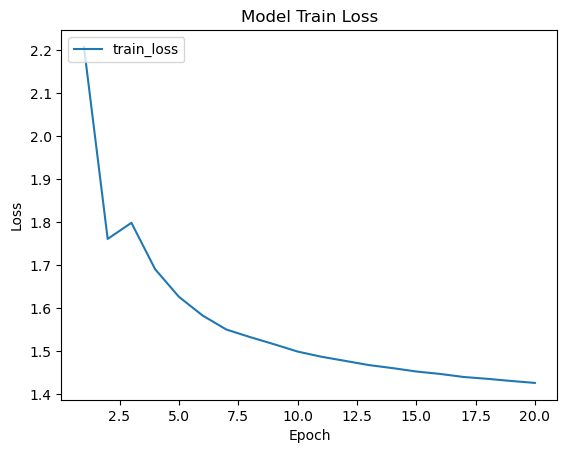

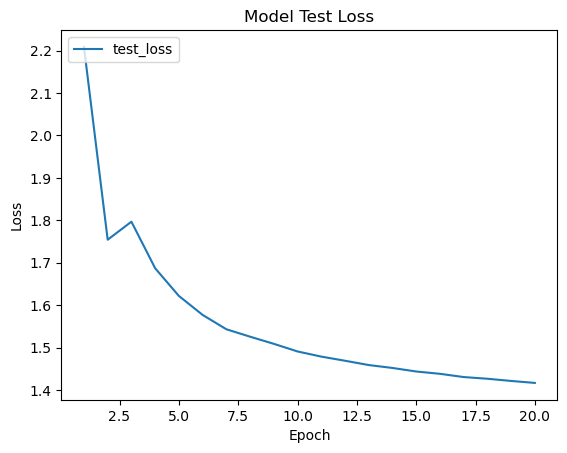

In [35]:
plot_graph(train_eva_df,'Model Train Loss','Epoch','Loss',['loss'],['train_loss'])
plot_graph(test_eva_df,'Model Test Loss','Epoch','Loss',['loss'],['test_loss'])

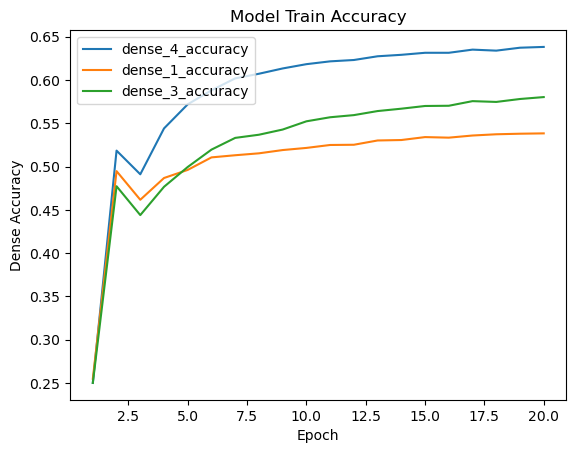

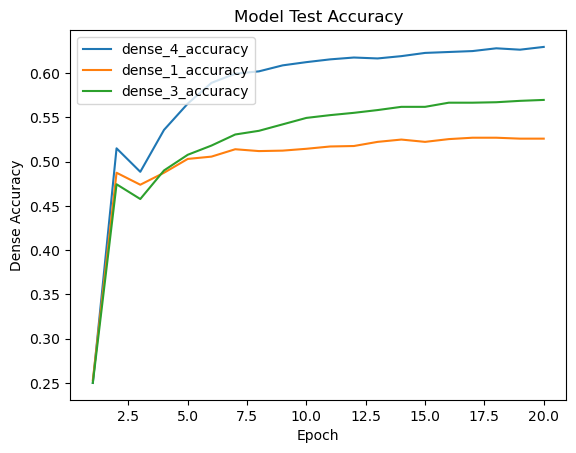

In [36]:
plot_graph(train_eva_df,'Model Train Accuracy','Epoch','Dense Accuracy',['dense_4_accuracy', 'dense_1_accuracy', 'dense_3_accuracy'])
plot_graph(test_eva_df,'Model Test Accuracy','Epoch','Dense Accuracy',['dense_4_accuracy', 'dense_1_accuracy', 'dense_3_accuracy'])

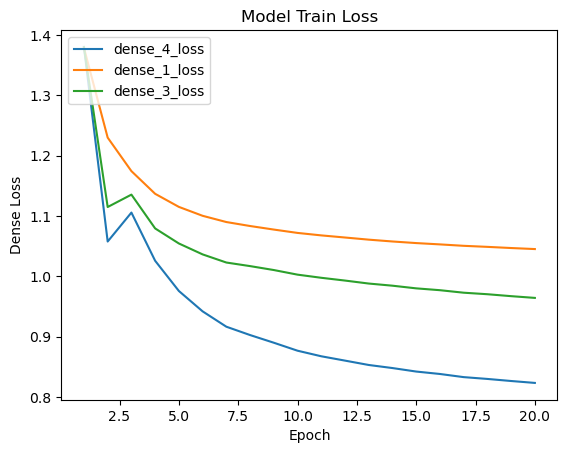

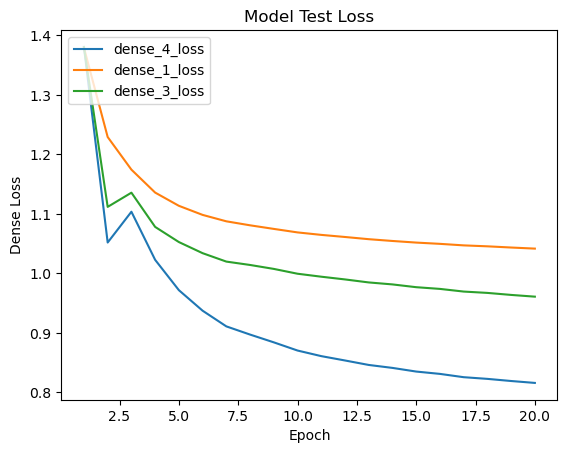

In [37]:
plot_graph(train_eva_df,'Model Train Loss','Epoch','Dense Loss',['dense_4_loss', 'dense_1_loss', 'dense_3_loss'])
plot_graph(test_eva_df,'Model Test Loss','Epoch','Dense Loss',['dense_4_loss', 'dense_1_loss', 'dense_3_loss'])

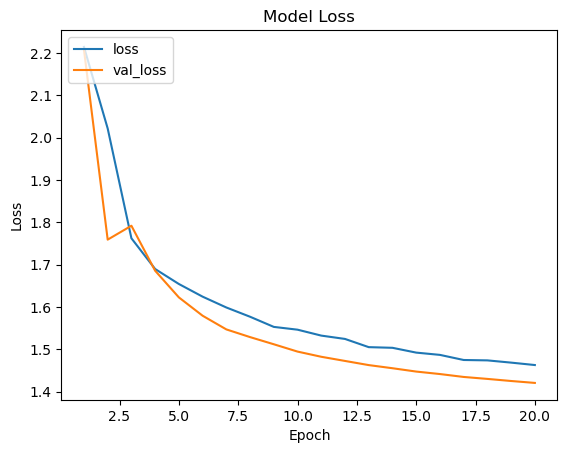

In [38]:
plot_graph(history_dataframe,'Model Loss','Epoch','Loss',['loss','val_loss'])

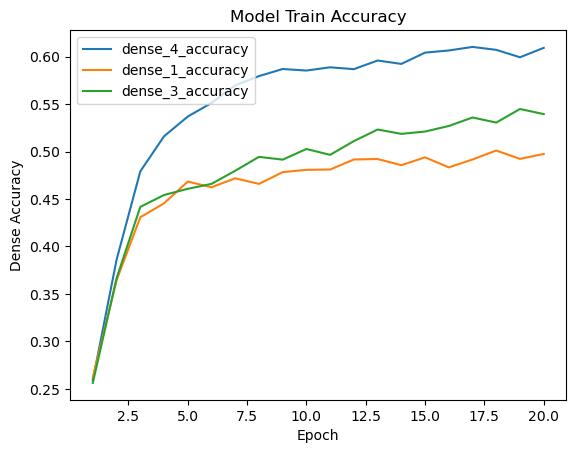

In [39]:
plot_graph(history_dataframe,'Model Train Accuracy','Epoch','Dense Accuracy',['dense_4_accuracy', 'dense_1_accuracy', 'dense_3_accuracy'])

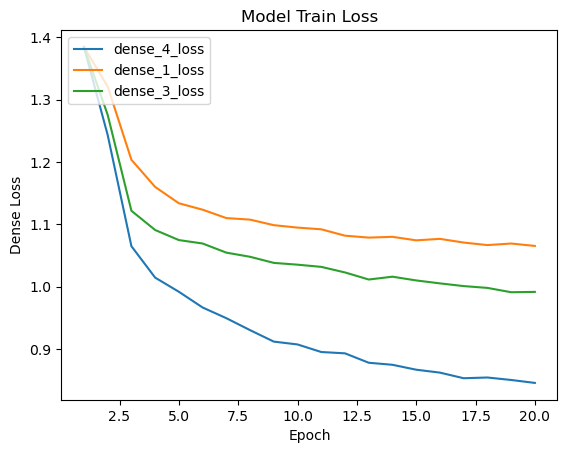

In [40]:
plot_graph(history_dataframe,'Model Train Loss','Epoch','Dense Loss',['dense_4_loss', 'dense_1_loss', 'dense_3_loss'])

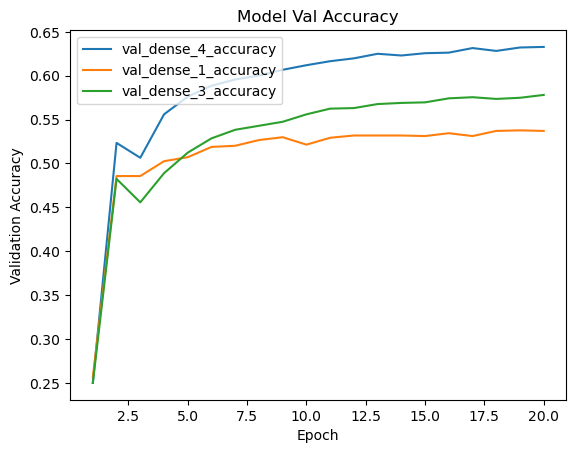

In [41]:
plot_graph(history_dataframe,'Model Val Accuracy','Epoch','Validation Accuracy',['val_dense_4_accuracy', 'val_dense_1_accuracy', 'val_dense_3_accuracy'])

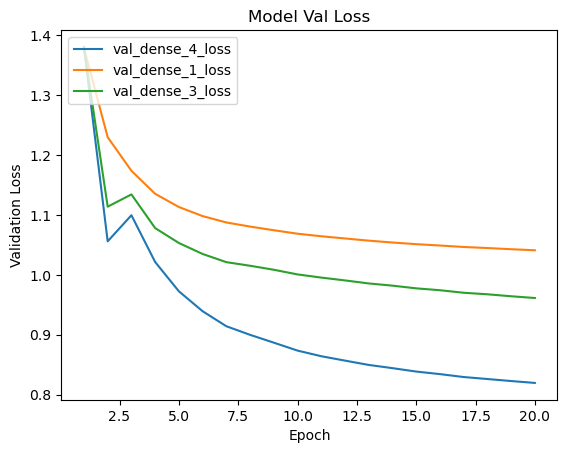

In [42]:
plot_graph(history_dataframe,'Model Val Loss','Epoch','Validation Loss',['val_dense_4_loss', 'val_dense_1_loss', 'val_dense_3_loss'])

In [43]:
VARIETIES

['HD 3086', 'PBW 291', 'DBW 187', 'DBW222']

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

60/60 [==============================] - 59s 959ms/step


In [45]:
y_pred_labels = np.argmax(y_pred, axis=2)

In [46]:
for y_pred_label in y_pred_labels:
    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))

Accuracy: 0.6296875
Confusion Matrix:
[[207  39  29 205]
 [  7 346  87  40]
 [  0  40 382  58]
 [141  35  30 274]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.43      0.50       480
           1       0.75      0.72      0.74       480
           2       0.72      0.80      0.76       480
           3       0.47      0.57      0.52       480

    accuracy                           0.63      1920
   macro avg       0.63      0.63      0.63      1920
weighted avg       0.63      0.63      0.63      1920

Accuracy: 0.5260416666666666
Confusion Matrix:
[[207  30  61 182]
 [  1 282 133  64]
 [  7 108 285  80]
 [155  18  71 236]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.43      0.49       480
           1       0.64      0.59      0.61       480
           2       0.52      0.59      0.55       480
           3       0.42      0.49      0.45       480

    accu

In [47]:
tic = start_timer()
for x in range(20,30):
    print("\nEpoch: ",x+1)
    history = model.fit(x_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, validation_data=(x_val, y_val), shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    print("for testing")
    test_eva.append(model.evaluate(test_dataset,test_dataset_label))
    print("for training")
    train_eva.append(model.evaluate(train_dataset,train_dataset_label))
toc = end_timer()
show_time(tic,toc)

Testing started

Epoch:  21
768/768 - 2066s - loss: 1.4600 - dense_4_loss: 0.8428 - dense_1_loss: 1.0628 - dense_3_loss: 0.9944 - dense_4_accuracy: 0.6069 - dense_1_accuracy: 0.4953 - dense_3_accuracy: 0.5387 - val_loss: 1.4163 - val_dense_4_loss: 0.8170 - val_dense_1_loss: 1.0393 - val_dense_3_loss: 0.9584 - val_dense_4_accuracy: 0.6354 - val_dense_1_accuracy: 0.5352 - val_dense_3_accuracy: 0.5781 - 2066s/epoch - 3s/step
for testing
60/60 [==============================] - 60s 993ms/step - loss: 1.4120 - dense_4_loss: 0.8128 - dense_1_loss: 1.0399 - dense_3_loss: 0.9577 - dense_4_accuracy: 0.6313 - dense_1_accuracy: 0.5292 - dense_3_accuracy: 0.5693
for training
240/240 [==============================] - 234s 977ms/step - loss: 1.4219 - dense_4_loss: 0.8204 - dense_1_loss: 1.0435 - dense_3_loss: 0.9613 - dense_4_accuracy: 0.6404 - dense_1_accuracy: 0.5382 - dense_3_accuracy: 0.5805

Epoch:  22
768/768 - 2074s - loss: 1.4556 - dense_4_loss: 0.8411 - dense_1_loss: 1.0618 - dense_3_loss:

In [48]:
history_dataframe

,loss,dense_4_loss,dense_1_loss,dense_3_loss,dense_4_accuracy,dense_1_accuracy,dense_3_accuracy,val_loss,val_dense_4_loss,val_dense_1_loss,val_dense_3_loss,val_dense_4_accuracy,val_dense_1_accuracy,val_dense_3_accuracy
0,2.214775,1.384218,1.384115,1.384402,0.258952,0.262044,0.256185,2.208357,1.380589,1.379005,1.380222,0.250000,0.256510,0.250000
1,2.021991,1.243097,1.320873,1.275432,0.385905,0.364421,0.366374,1.759118,1.055998,1.229847,1.113886,0.523438,0.485677,0.482422
2,1.762357,1.064846,1.203415,1.121621,0.479167,0.430827,0.441732,1.791978,1.099549,1.173777,1.134317,0.506510,0.485677,0.455729
3,1.689657,1.014455,1.159867,1.090802,0.516113,0.445475,0.454264,1.685558,1.021504,1.135391,1.078120,0.555990,0.502604,0.488932
4,1.654222,0.991729,1.133662,1.074642,0.536947,0.468424,0.460775,1.622526,0.972570,1.113289,1.053230,0.576172,0.507161,0.512370
5,1.624287,0.966531,1.123374,1.069150,0.551270,0.462402,0.465983,1.579232,0.939312,1.098149,1.034918,0.588542,0.518880,0.528646
6,1.598696,0.949377,1.109904,1.054494,0.569824,0.471842,0.479818,1.546858,0.914236,1.087496,1.021246,0.595703,0.520182,0.538411
7,1.576794,0.930204,1.107439,1.047858,0.579590,0.465983,0.494466,1.528654,0.899895,1.080647,1.015216,0.600260,0.526693,0.542969
8,1.552793,0.911810,1.098546,1.038064,0.587077,0.478353,0.491536,1.511747,0.886830,1.074517,1.008538,0.606771,0.529948,0.547526
9,1.546219,0.907263,1.094654,1.035195,0.585449,0.480794,0.502767,1.494415,0.873573,1.068724,1.000752,0.611979,0.521484,0.555990


In [49]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','dense_4_loss','dense_1_loss','dense_3_loss','dense_4_accuracy','dense_1_accuracy','dense_3_accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','dense_4_loss','dense_1_loss','dense_3_loss','dense_4_accuracy','dense_1_accuracy','dense_3_accuracy'])

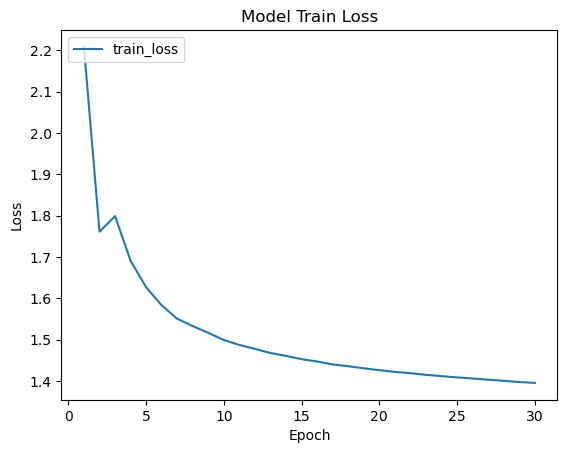

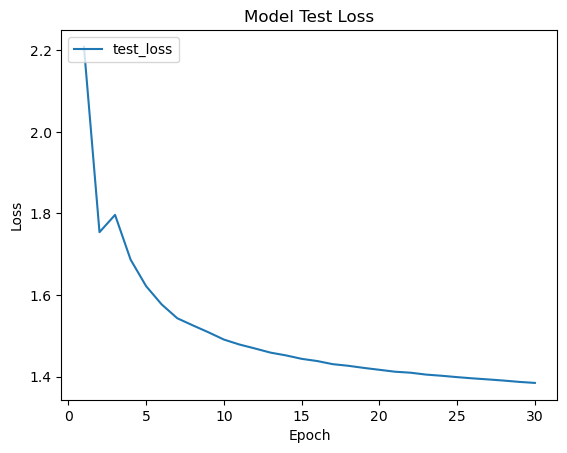

In [50]:
plot_graph(train_eva_df,'Model Train Loss','Epoch','Loss',['loss'],['train_loss'])
plot_graph(test_eva_df,'Model Test Loss','Epoch','Loss',['loss'],['test_loss'])

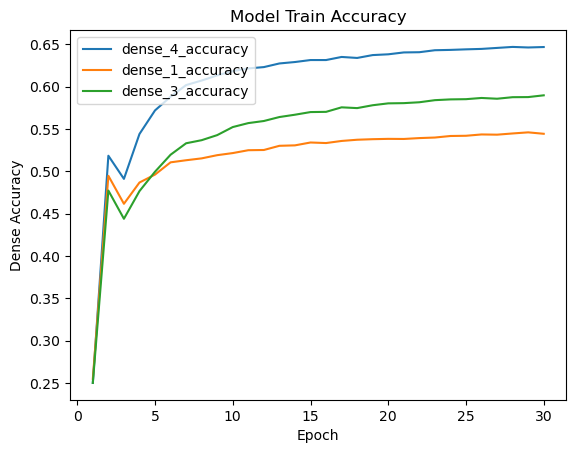

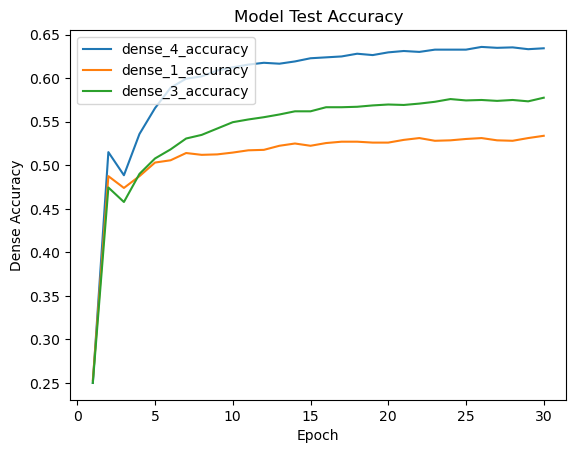

In [51]:
plot_graph(train_eva_df,'Model Train Accuracy','Epoch','Dense Accuracy',['dense_4_accuracy', 'dense_1_accuracy', 'dense_3_accuracy'])
plot_graph(test_eva_df,'Model Test Accuracy','Epoch','Dense Accuracy',['dense_4_accuracy', 'dense_1_accuracy', 'dense_3_accuracy'])

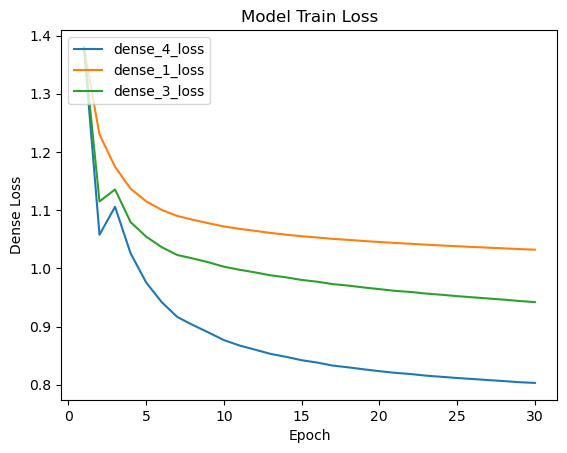

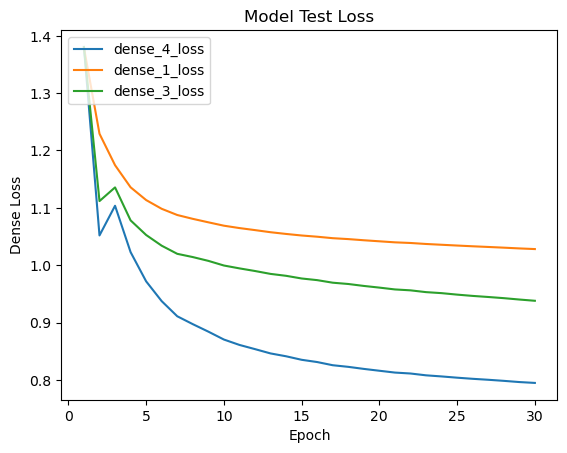

In [52]:
plot_graph(train_eva_df,'Model Train Loss','Epoch','Dense Loss',['dense_4_loss', 'dense_1_loss', 'dense_3_loss'])
plot_graph(test_eva_df,'Model Test Loss','Epoch','Dense Loss',['dense_4_loss', 'dense_1_loss', 'dense_3_loss'])

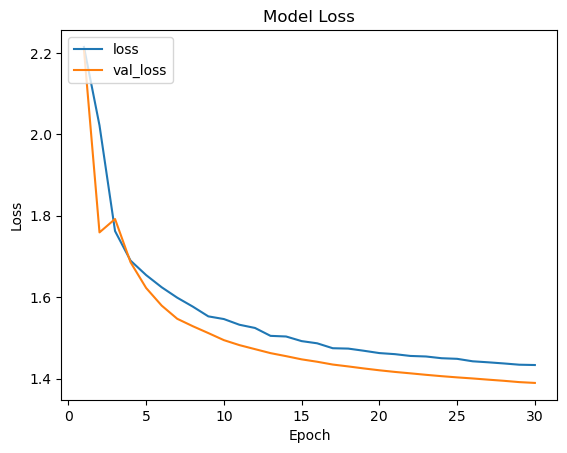

In [53]:
plot_graph(history_dataframe,'Model Loss','Epoch','Loss',['loss','val_loss'])

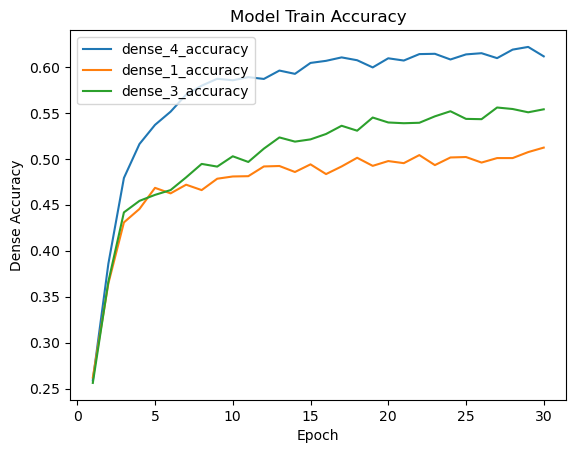

In [54]:
plot_graph(history_dataframe,'Model Train Accuracy','Epoch','Dense Accuracy',['dense_4_accuracy', 'dense_1_accuracy', 'dense_3_accuracy'])

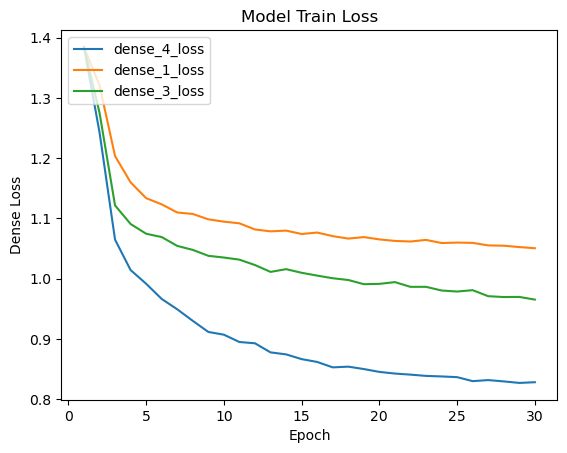

In [55]:
plot_graph(history_dataframe,'Model Train Loss','Epoch','Dense Loss',['dense_4_loss', 'dense_1_loss', 'dense_3_loss'])

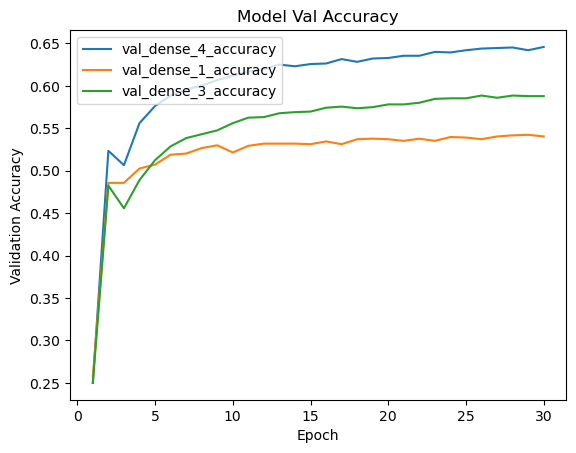

In [56]:
plot_graph(history_dataframe,'Model Val Accuracy','Epoch','Validation Accuracy',['val_dense_4_accuracy', 'val_dense_1_accuracy', 'val_dense_3_accuracy'])

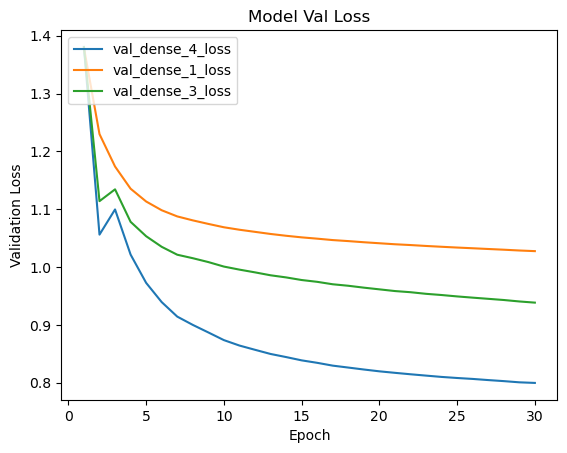

In [57]:
plot_graph(history_dataframe,'Model Val Loss','Epoch','Validation Loss',['val_dense_4_loss', 'val_dense_1_loss', 'val_dense_3_loss'])

In [58]:
VARIETIES

['HD 3086', 'PBW 291', 'DBW 187', 'DBW222']

In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

60/60 [==============================] - 58s 959ms/step


In [60]:
y_pred_labels = np.argmax(y_pred, axis=2)

In [61]:
for y_pred_label in y_pred_labels:
    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))

Accuracy: 0.634375
Confusion Matrix:
[[180  44  30 226]
 [  5 357  83  35]
 [  0  42 390  48]
 [120  36  33 291]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.38      0.46       480
           1       0.75      0.74      0.74       480
           2       0.73      0.81      0.77       480
           3       0.48      0.61      0.54       480

    accuracy                           0.63      1920
   macro avg       0.64      0.63      0.63      1920
weighted avg       0.64      0.63      0.63      1920

Accuracy: 0.5338541666666666
Confusion Matrix:
[[190  31  64 195]
 [  0 285 135  60]
 [  6 102 298  74]
 [137  20  71 252]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47       480
           1       0.65      0.59      0.62       480
           2       0.52      0.62      0.57       480
           3       0.43      0.53      0.48       480

    accur